In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from matplotlib.colors import SymLogNorm, LogNorm
from astropy import units as u
import os
from lxml import etree
from mpl_toolkits import mplot3d
import time
%matplotlib inline

In [2]:
def plot_skymap(file, name='skymap.png', title=None, xlabel='right ascension (deg)', 
                     ylabel='declination (deg)', figsize=(10, 10), fontsize=20, cmap='gist_heat'):
    # get map
    fig = plt.figure(figsize=figsize) 
    ax = plt.subplot(projection=wcs)
    img = plt.imshow(file, norm=SymLogNorm(1), interpolation='gaussian', cmap=cmap)
    ax.coords[0].set_format_unit(u.deg) 
    ax.coords[1].set_format_unit(u.deg)
    cb = plt.colorbar(img, ax=ax)
    # axis
    ax.tick_params(axis='both', labelsize=fontsize)
    cb.ax.tick_params(labelsize=fontsize) 
    cb.set_label('counts', fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.grid(color='grey', ls='solid')
    fig.savefig(name)
    plt.show()
    return 

def plot3d_skymap(skymap):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:skymap.shape[0], 0:skymap.shape[1]]

    # create the figure
    ax = fig.gca(projection='3d')
    ax.plot_surface(xx, yy, skymap ,rstride=1, cstride=1, cmap='gist_heat',linewidth=0)

    # show it
    fig.savefig("3Dplot")
    plt.show()
    return

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""
class Timer:
    def __init__(self):
        self._start_time = None
        self.list_of_times = []
    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")
        self._start_time = time.perf_counter()
    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")
        global elapsed_time
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        self.list_of_times.append(elapsed_time)
        #print(f"Elapsed time: {elapsed_time:0.4f} seconds")

# Extraction of Database elements 

In [3]:
#dataset irf download
data_folder = os.path.join("..", "data")
xml_folder = os.path.join("..","models")
dataset = []
dataset_no_irf = []
total = 0
total_no_irf = 0
bkg = 0
bkg_no_irf = 0
single = 0
single_no_irf = 0
double = 0
double_no_irf = 0

#Order by name bkg-oneSource-twoSource
directory=os.listdir(data_folder)
directory.sort()
#data_folder -> directory w/ all fits folder
#dir_skymap -> directories w/ fits file (single source, bkg, double, ...)
#we need to sort files inside data_folder to order the elements in the dataset

for dir_skymap in directory:  
    #get rid of useless file for example ipycheckpoint
    if(os.path.isdir(os.path.join(data_folder, dir_skymap))): 
        
        #sorting of fits files to match-up with the element in model parameter extraction 
        temp=os.path.join(data_folder, dir_skymap)
        sub_directory=os.listdir(temp)
        sub_directory.sort()
        
        #iterate for all files inside the given dir_skymap
        for crab_skymap in sub_directory:
            if(dir_skymap == "backgroundSimulations"):
                bkg+=1
                total+=1
                with fits.open((os.path.join(data_folder, dir_skymap, crab_skymap))) as hdul:
                    wcs = WCS(hdul[0].header)
                    dataset.append((hdul[0].data,wcs,crab_skymap,None))
            elif(dir_skymap == "backgroundSimulationsNoBkgSub"):
                bkg_no_irf+=1
                total_no_irf+=1
                with fits.open((os.path.join(data_folder, dir_skymap, crab_skymap))) as hdul:
                    wcs = WCS(hdul[0].header)
                    dataset_no_irf.append((hdul[0].data,wcs,crab_skymap,None)) 
            elif((dir_skymap == 'sourceSimulationsNoBkgSub') or (dir_skymap == 'twoSourcesSimulationsNoBkgSub')):
                with fits.open((os.path.join(data_folder, dir_skymap, crab_skymap))) as hdul:
                    wcs = WCS(hdul[0].header)
                    dataset_no_irf.append((hdul[0].data,wcs,crab_skymap))
            else:
                with fits.open((os.path.join(data_folder, dir_skymap, crab_skymap))) as hdul:
                    wcs = WCS(hdul[0].header)
                    dataset.append((hdul[0].data,wcs,crab_skymap))
                    
directory=os.listdir(xml_folder)
#Remove of useless directories
if os.path.isdir(os.path.join(xml_folder, 'backgroundModels')):
    os.rmdir(os.path.join(xml_folder, 'backgroundModels'))
if os.path.isdir(os.path.join(xml_folder, 'backgroundModelsNoBkgSub')):    
    os.rmdir(os.path.join(xml_folder, 'backgroundModelsNoBkgSub'))
    
#sort of sub directories    
directory.sort()    
for xml_subfolder in directory:
    temp=os.path.join(xml_folder, xml_subfolder)
    #there are model files inside the xml_folder 
    if(os.path.isdir(temp)):
        #sorting of xml files to match-up with the element in ther dataset
        sub_directory=os.listdir(temp)
        sub_directory.sort()
        if(xml_subfolder == "sourceModels"):
            for xml_file in sub_directory:
                with open(os.path.join(xml_folder, xml_subfolder, xml_file), 'rb') as xml_file:
                    tree =  etree.parse(xml_file) 
                    root = tree.getroot()
                    Ra = float(root[0][1][0].get("value"))
                    Dec = float(root[0][1][1].get("value"))
                    dataset[total] +=((Ra,Dec),)
                    total+=1
                    single+=1
        if(xml_subfolder == "sourceModelsNoBkgSub"):
            for xml_file in sub_directory:
                with open(os.path.join(xml_folder, xml_subfolder, xml_file), 'rb') as xml_file:
                    tree =  etree.parse(xml_file) 
                    root = tree.getroot()
                    Ra = float(root[0][1][0].get("value"))
                    Dec = float(root[0][1][1].get("value"))
                    dataset_no_irf[total_no_irf] +=((Ra,Dec),)
                    total_no_irf+=1
                    single_no_irf+=1
        if(xml_subfolder == "twoSourcesModels"):
            for xml_file in sub_directory:
                with open(os.path.join(xml_folder, xml_subfolder, xml_file), 'rb') as xml_file:
                    tree =  etree.parse(xml_file) 
                    root = tree.getroot()
                    Ra = float(root[0][1][0].get("value"))
                    Dec = float(root[0][1][1].get("value"))
                    Ra2 = float(root[1][1][0].get("value"))
                    Dec2 = float(root[1][1][1].get("value"))
                    dataset[total] +=((Ra,Dec,Ra2,Dec2),)
                    total+=1
                    double+=1
        if(xml_subfolder == "twoSourcesModelsNoBkgSub"):
            for xml_file in sub_directory:
                with open(os.path.join(xml_folder, xml_subfolder, xml_file), 'rb') as xml_file:
                    tree =  etree.parse(xml_file)
                    root = tree.getroot()
                    Ra = float(root[0][1][0].get("value"))
                    Dec = float(root[0][1][1].get("value"))
                    Ra2 = float(root[1][1][0].get("value"))
                    Dec2 = float(root[1][1][1].get("value"))
                    dataset_no_irf[total_no_irf] +=((Ra,Dec,Ra2,Dec2),)
                    total_no_irf+=1
                    double_no_irf+=1

print("number of total entries with irf: ",total)
print("number of total entries No IRF: ",total_no_irf)
print("number of backgrounds: ",bkg)
print("number of backgrounds No IRF: ",bkg_no_irf)
print("numebr of entries of single source: ",single)
print("numebr of entries of single source No IRF: ",single_no_irf)
print("number of entries of double sources: ",double)   
print("number of entries of double sources No IRF: ",double_no_irf) 

Set MJD-END to 51544.000000 from DATE-END'. [astropy.wcs.wcs]


number of total entries with irf:  250
number of total entries No IRF:  250
number of backgrounds:  40
number of backgrounds No IRF:  40
numebr of entries of single source:  105
numebr of entries of single source No IRF:  105
number of entries of double sources:  105
number of entries of double sources No IRF:  105


# Definition of custom kernel 

In [5]:
def kernel(n,k,c):
    centre = n//2
    kernel = np.ones((n,n))
    ncells = np.sum(kernel)
    n_corecells = (k*2+1)**2
    n_outercells = ncells-n_corecells
    kernel[centre-k:centre+k+1,centre-k:centre+k+1] = -n_outercells/n_corecells
    kernel = kernel/-n_outercells * c   
    return kernel

# Source acquisition with custom kernels 

In [13]:
dataset_source =  dataset_no_irf + dataset #taking into consideration the complete dataset
t = Timer()

results = []
chessboard_error = []
images = []

threshold = 190 

px,py,px2,py2 = (0,0,0,0)

for skymap,wcs,name,source_position in dataset_source:
#plot_skymap(skymap,"skymap_original.jpg")

    t.start()
    
    #image format
    min_value = np.min(skymap)
    skymap = skymap + abs(min_value)
    skymap[skymap < 0] = 0
    skymap[skymap > 255] = 255
    np.rint(skymap)
    skymap = skymap.astype("uint8")
#   plot_skymap(skymap,"skymap_integer.jpg")
    
    
    #image filtering
    skymap_custom = cv2.filter2D(skymap,-1,kernel(51,0,15))
#   plot_skymap(skymap_custom,name = 'skymap_conv1.jpg')
    
    kernel3 = np.ones((10,10))
    skymap_custom = cv2.filter2D(skymap_custom,-1,kernel3/np.sum(kernel3))
#   plot_skymap(skymap_custom,name = "skymap_conv2.jpg")

    skymap_custom = cv2.filter2D(skymap_custom,-1,kernel(51,2,10))
#   plot_skymap(skymap_custom,name = 'skymap_conv3.jpg')
    
    kernel3 = np.ones((15,15))
    skymap_custom = cv2.filter2D(skymap_custom,-1,kernel3/np.sum(kernel3))
#   plot_skymap(skymap_custom,name = 'skymap_conv4.jpg')
    
    skymap = cv2.filter2D(skymap_custom,-1,kernel(51,5,5))
#   plot_skymap(skymap_custom,'skymap_conv5.jpg')

    binary_skymap = np.copy(skymap)
    binary_skymap[binary_skymap < threshold] = 0
    binary_skymap[binary_skymap >= threshold] = 255
#   plot_skymap(binary_skymap,'skymap_binary.jpg')

    #blob detection
    params = cv2.SimpleBlobDetector_Params()
    
    params.filterByArea = False
    params.minArea = 10

    params.filterByColor = False    
    params.blobColor = 255    

    # Set Circularity filtering parameters
    params.filterByCircularity = True
    params.minCircularity = 0.7

    # Set Convexity filtering parameters
    params.filterByConvexity = False
    params.minConvexity = 0.2

    # Set inertia filtering parameters
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs
    image = np.copy(binary_skymap)
    keypoints = detector.detect(binary_skymap)
    number_of_blobs = len(keypoints)
    
    if number_of_blobs > 0: 
        px = int(keypoints[0].pt[0])
        py = int(keypoints[0].pt[1])

    if number_of_blobs > 1:
        px2 = int(keypoints[1].pt[0])
        py2 = int(keypoints[1].pt[1]) 

    t.stop()
    
    images.append(image)   
    
    #checking for errors
    if source_position == None:
        results.append(number_of_blobs == 0)
    elif len(source_position) == 2:
        ra,dec = source_position
        coordinates = SkyCoord(ra,dec,unit='deg')
        px_true,py_true = wcs.world_to_pixel(coordinates)
        px_true,py_true = (int(px_true),int(py_true))
        
        error = max(abs(px-px_true),abs(py-py_true))
        chessboard_error.append(error)
        
        correct_number = number_of_blobs == 1
        correct_position = error <= 2
        
        results.append(correct_number and correct_position)

    else:
        ra,dec,ra2,dec2 = source_position
        coordinates = SkyCoord(ra,dec,unit='deg')
        coordinates2 = SkyCoord(ra2,dec2,unit='deg')
        
        px_true,py_true = wcs.world_to_pixel(coordinates)
        px_true,py_true = (int(px_true),int(py_true))
        
        px_true2,py_true2 = wcs.world_to_pixel(coordinates2)
        px_true2,py_true2 = (int(px_true2),int(py_true2))

        
        error = max(min(max(abs(px-px_true),abs(py-py_true)),max(abs(px2-px_true),abs(py2-py_true))),min(max(abs(px-px_true2),abs(py-py_true2)),max(abs(px2-px_true2),abs(py2-py_true2))))
        chessboard_error.append(error)
        correct_number = number_of_blobs == 2
        correct_position = error <= 2
        
        results.append(correct_number and correct_position)    
    
a = np.arange(len(results))
results = np.array(results)
errors = a[results==False]
nr = sum(results)
ne = len(errors)

print("mean computation time for image:",end=" ")
print(sum(t.list_of_times)/len(t.list_of_times))

print("accuracy:",end=" ")
print(nr/(nr+ne))
        

mean computation time for image: 0.024762441503998617
accuracy: 0.952


# Plot of the skymaps with wrong source detection 

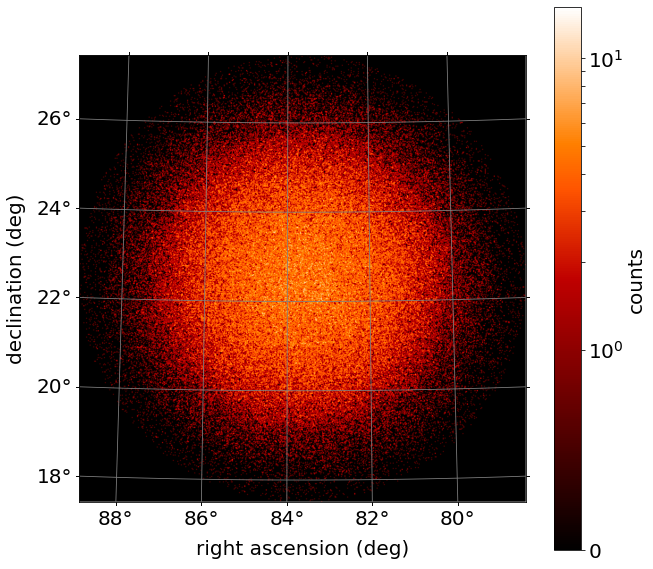

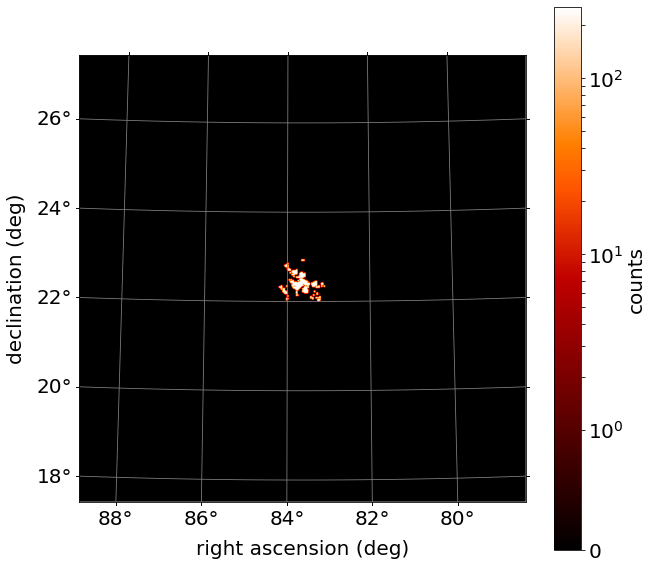

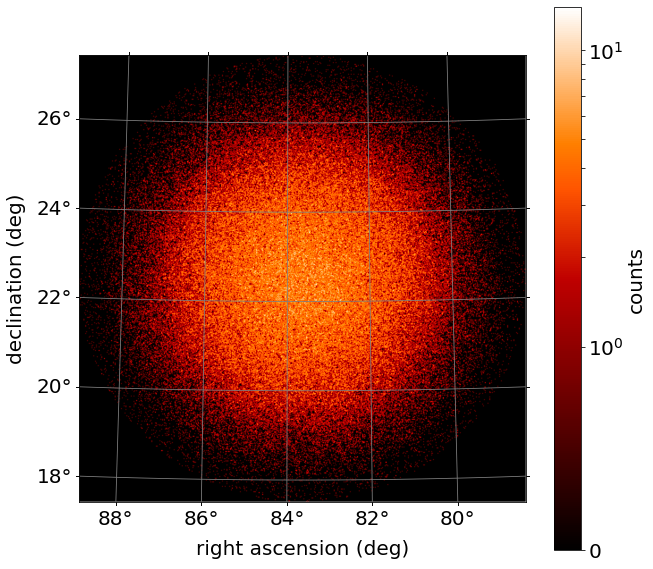

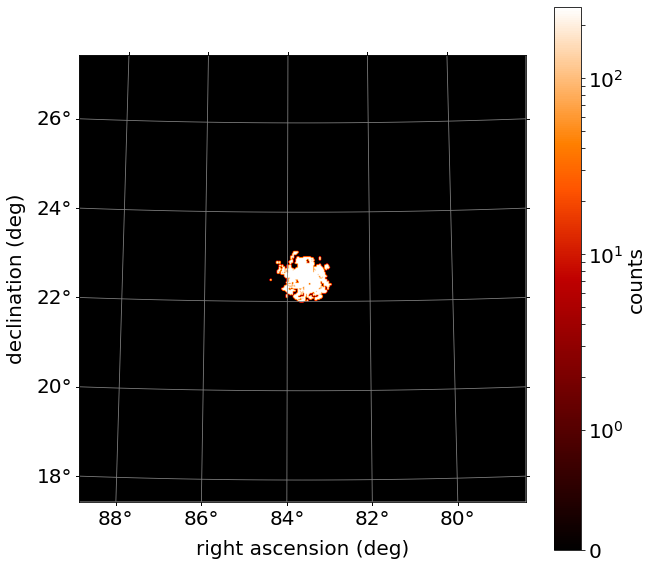

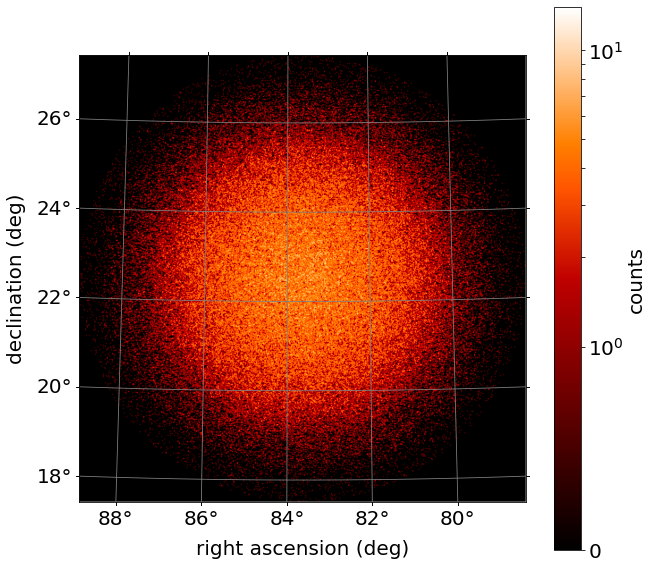

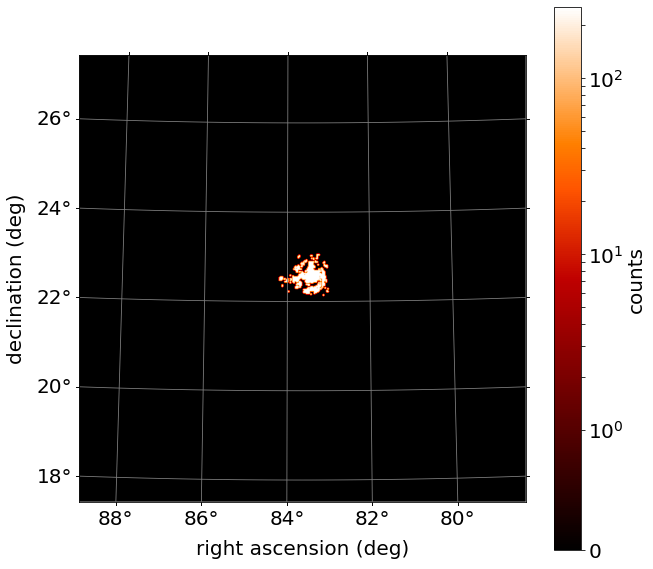

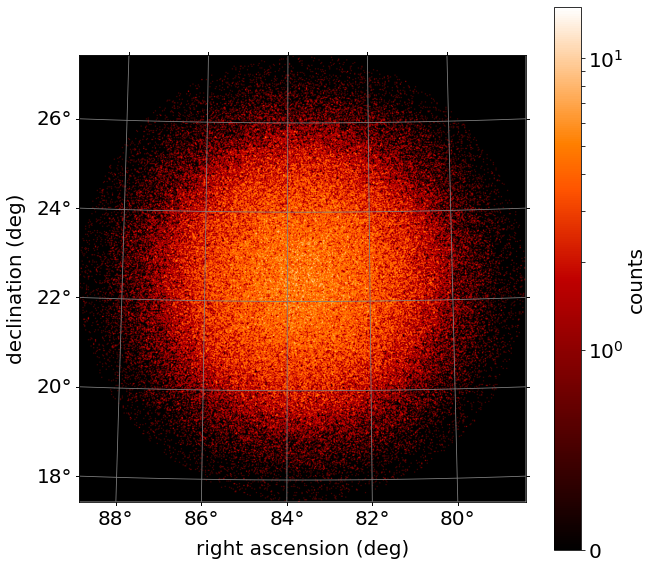

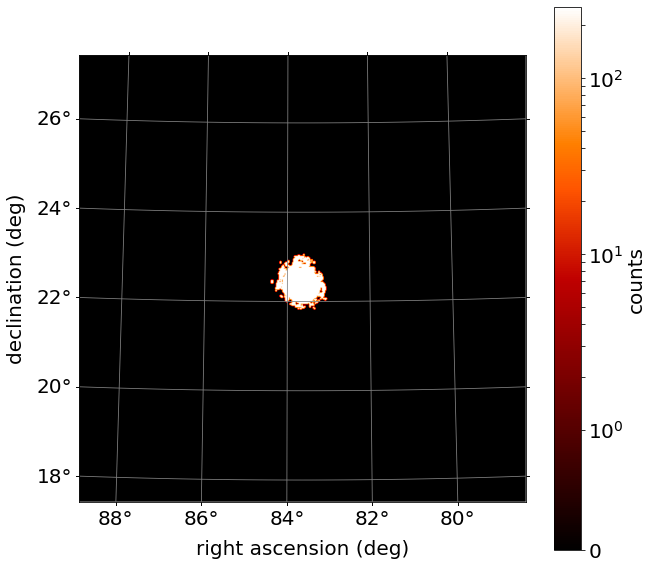

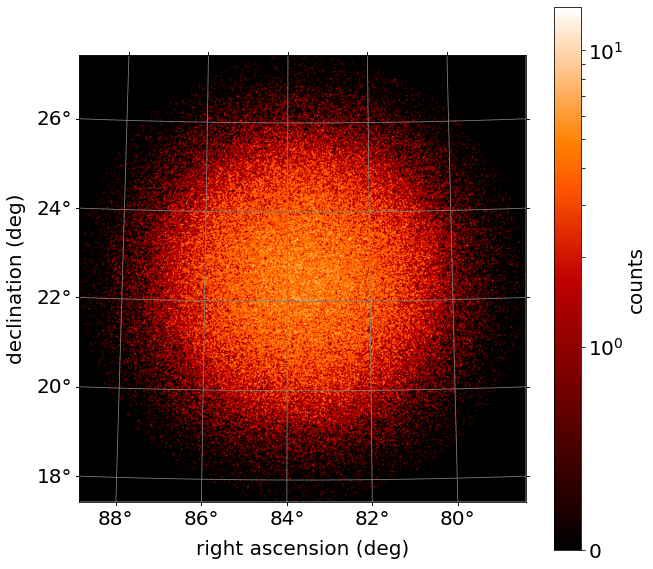

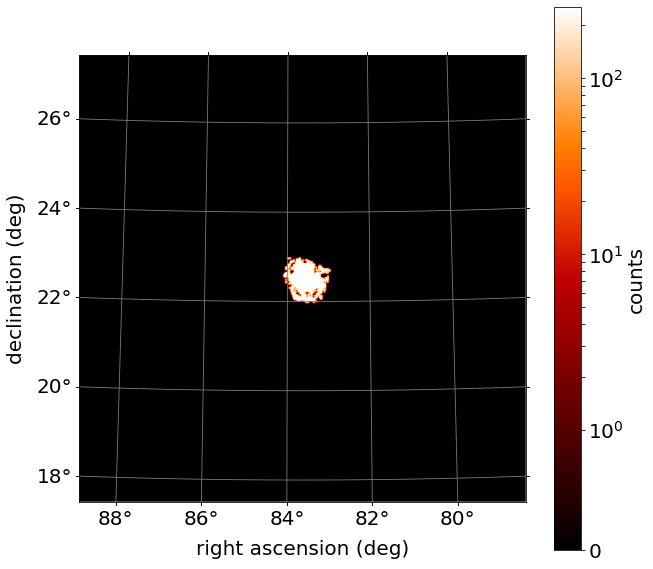

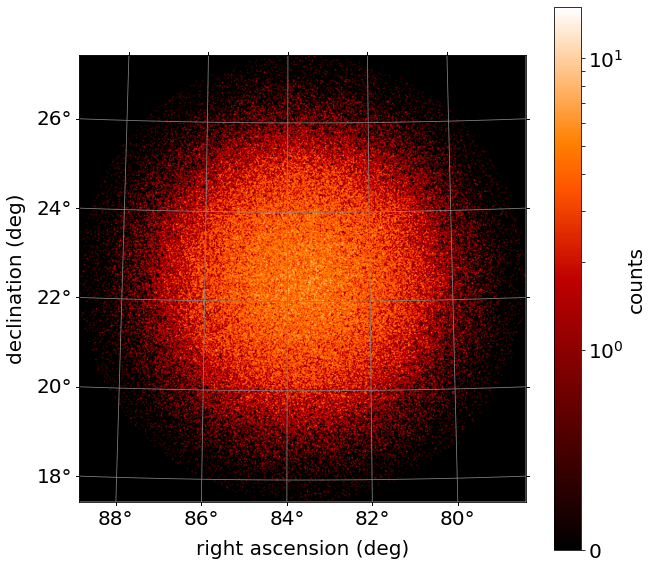

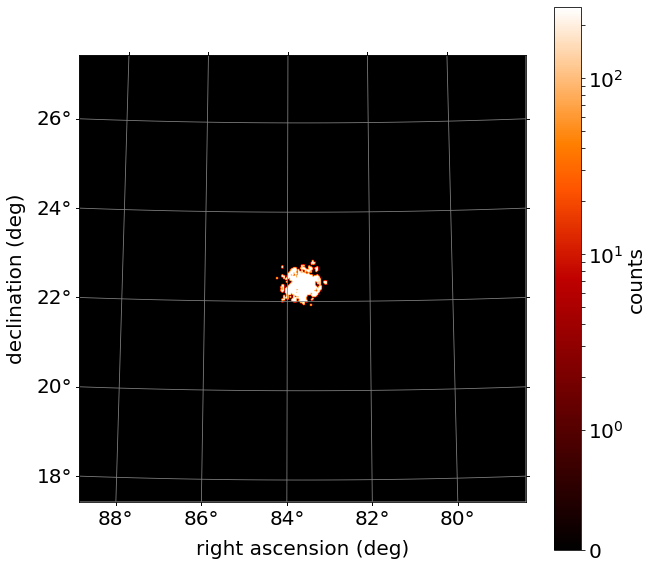

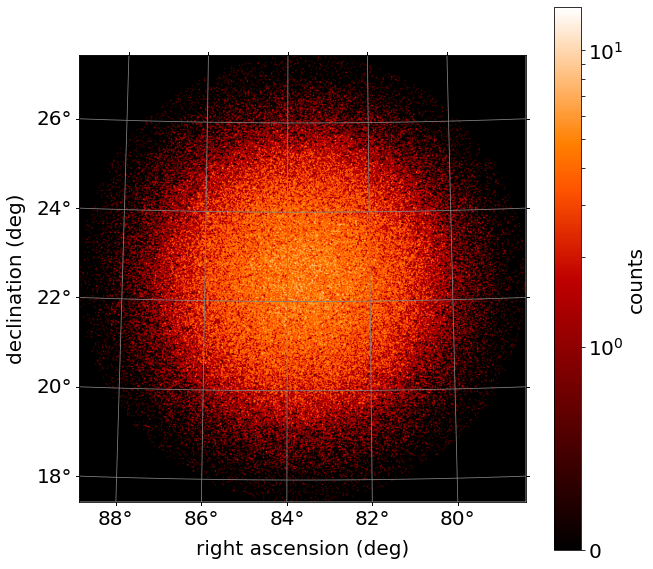

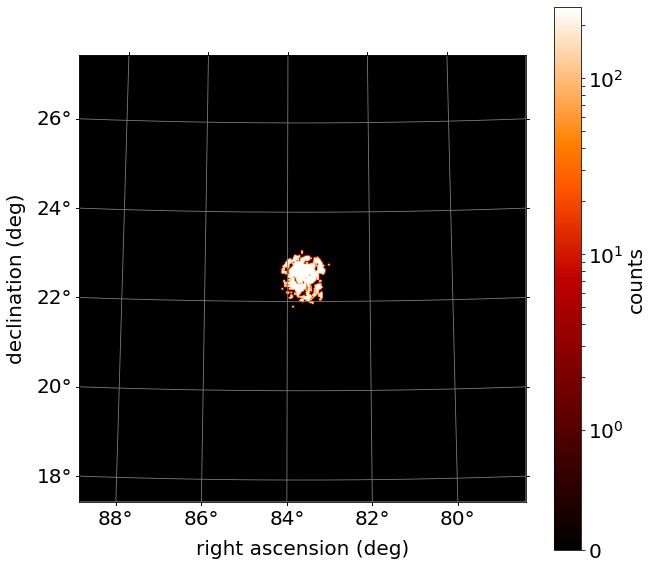

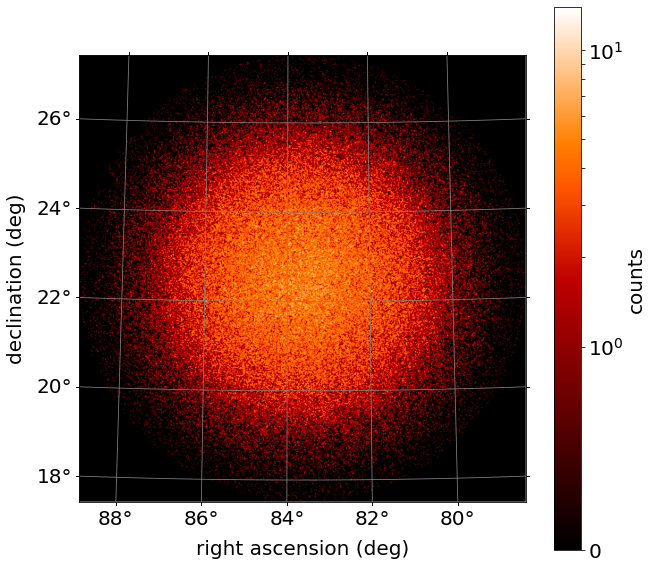

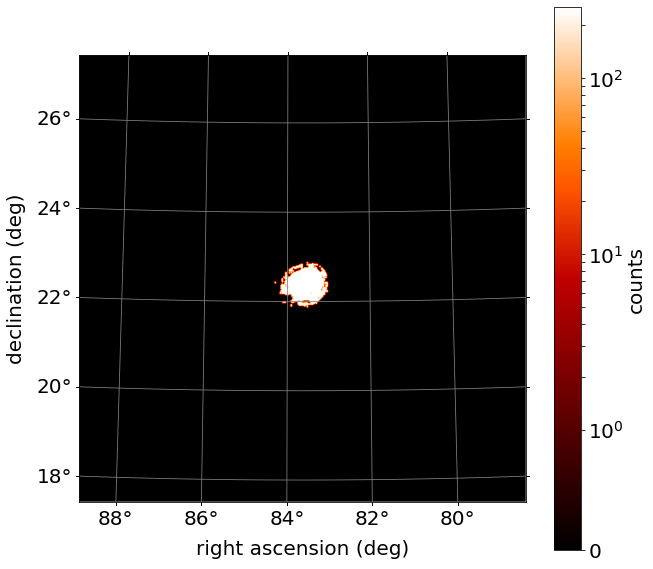

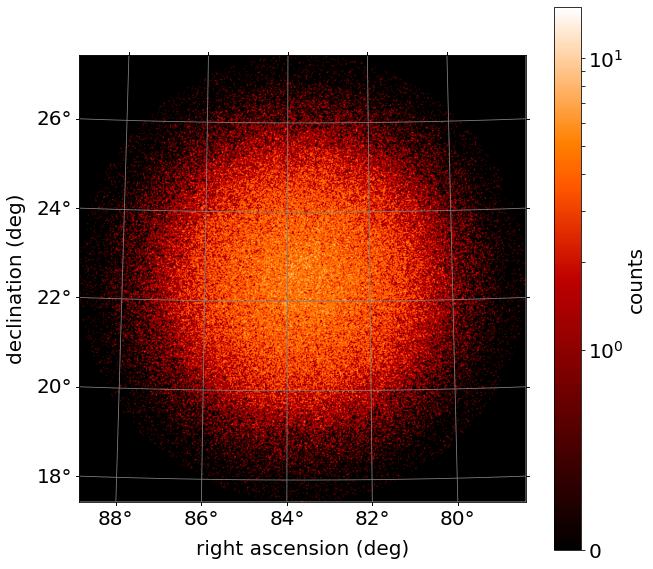

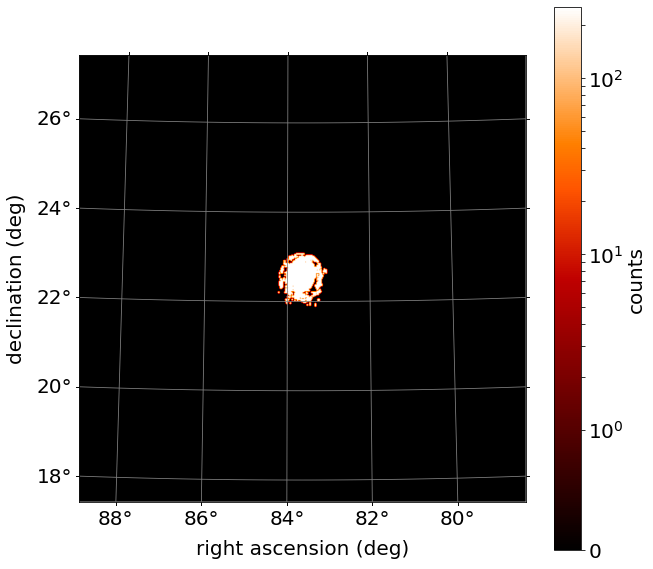

SystemError: <built-in method write of _io.BufferedWriter object at 0x000001DFFBDB7D58> returned a result with an error set

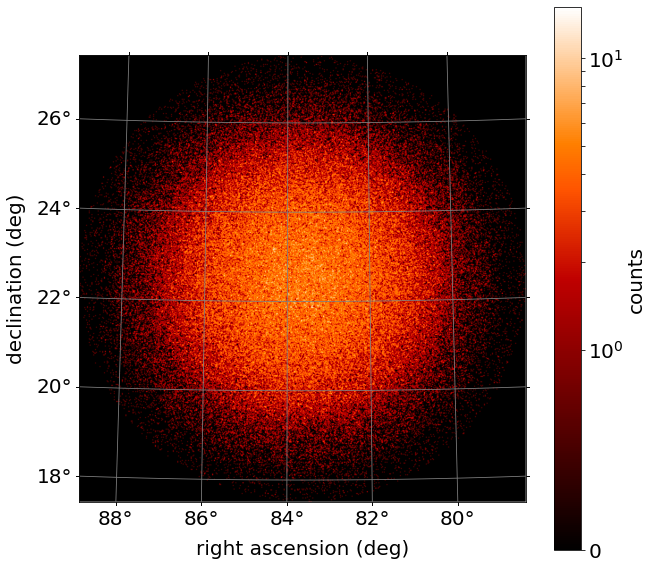

In [11]:
for i in errors:
    plot_skymap(dataset_source[i][0])
    plot_skymap(images[i])


# Alternative solution with Median and Bilateral

In [14]:
dataset_source =  dataset
t = Timer()

results = []
chessboard_error = []
images = []

threshold = 7 

px,py,px2,py2 = (0,0,0,0)

for skymap,wcs,name,source_position in dataset_source:
#plot_skymap(skymap,"skymap_original.jpg")

    t.start()
    
    #image format
    min_value = np.min(skymap)
    skymap = skymap + abs(min_value)
    skymap[skymap < 0] = 0
    skymap[skymap > 255] = 255
    np.rint(skymap)
    skymap = skymap.astype("uint8")
#   plot_skymap(skymap,"skymap_integer.jpg")
    
    #image filtering
    skymap = cv2.medianBlur(skymap, 5) 
#   plot_skymap(skymap)
    
    skymap = cv2.bilateralFilter(skymap,-1,2,18)
#   plot_skymap(skymap,"skymap_bilateral.jpg")
    
    binary_skymap = np.copy(skymap)
    binary_skymap[binary_skymap < threshold] = 0
    binary_skymap[binary_skymap >= threshold] = 255
#   plot_skymap(binary_skymap,'skymap_binary.jpg')


    #Blob detection
    params = cv2.SimpleBlobDetector_Params()
    
    params.filterByArea = False
    params.minArea = 10

    params.filterByColor = False    
    params.blobColor = 255    

    # Set Circularity filtering parameters
    params.filterByCircularity = True
    params.minCircularity = 0.5

    # Set Convexity filtering parameters
    params.filterByConvexity = False
    params.minConvexity = 0.2

    # Set inertia filtering parameters
    params.filterByInertia = False
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs
    image = np.copy(binary_skymap)
    keypoints = detector.detect(binary_skymap)
    number_of_blobs = len(keypoints)
    
    
    if number_of_blobs > 0: 
        px = int(keypoints[0].pt[0])
        py = int(keypoints[0].pt[1])

    if number_of_blobs > 1:
        px2 = int(keypoints[1].pt[0])
        py2 = int(keypoints[1].pt[1]) 

    t.stop()
    
    images.append(image)   
    
    #checking for errors
    if source_position == None:
        results.append(number_of_blobs == 0)
    elif len(source_position) == 2:
        ra,dec = source_position
        coordinates = SkyCoord(ra,dec,unit='deg')
        px_true,py_true = wcs.world_to_pixel(coordinates)
        px_true,py_true = (int(px_true),int(py_true))
        
        error = max(abs(px-px_true),abs(py-py_true))
        chessboard_error.append(error)
        
        correct_number = number_of_blobs == 1
        correct_position = error <= 2
        
        results.append(correct_number and correct_position)

    else:
        ra,dec,ra2,dec2 = source_position
        coordinates = SkyCoord(ra,dec,unit='deg')
        coordinates2 = SkyCoord(ra2,dec2,unit='deg')
        
        px_true,py_true = wcs.world_to_pixel(coordinates)
        px_true,py_true = (int(px_true),int(py_true))
        
        px_true2,py_true2 = wcs.world_to_pixel(coordinates2)
        px_true2,py_true2 = (int(px_true2),int(py_true2))

        
        error = max(min(max(abs(px-px_true),abs(py-py_true)),max(abs(px2-px_true),abs(py2-py_true))),min(max(abs(px-px_true2),abs(py-py_true2)),max(abs(px2-px_true2),abs(py2-py_true2))))
        chessboard_error.append(error)
        correct_number = number_of_blobs == 2
        correct_position = error <= 2
        
        results.append(correct_number and correct_position)    
    
a = np.arange(len(results))
results = np.array(results)
errors = a[results==False]
nr = sum(results)
ne = len(errors)

print("mean computation time for image:",end=" ")
print(sum(t.list_of_times)/len(t.list_of_times))

print("accuracy:",end=" ")
print(nr/(nr+ne))

mean computation time for image: 0.5255680099560104
accuracy: 0.776


In [ ]:
#background normalization by median of the background without IRF

#copia della prima immagine di bkg 

mean = dataset[10][0]

#ciclo di lettura 
print(bkg)
print(bkgNoIRF)
for i in range(bkg,bkg+bkgNoIRF,1):
    skymap = np.copy(dataset[i][0])
    mean += skymap
    
plot_skymap(mean)    
subtraction = mean / bkgNoIRF
plot_skymap(subtraction)
#test immagine

#for sigma in range(1,4):
sigma=2
subtraction_gaussian = cv2.GaussianBlur(subtraction,(0,0),sigma,sigma)
plot3d_skymap(subtraction_gaussian)
plot_skymap(subtraction_gaussian)

In [ ]:
print('background without IRF')
for i in range(bkg,bkg+bkgNoIRF,1):
    skymap = np.copy(dataset[i][0])
    result = skymap - subtraction_gaussian
    result[result < 0] = 0
    result = result.astype("uint8")
    plot_skymap(result)
    
print('single sources without IRF')
#col meno
singleUp=single+bkg+bkgNoIRF
for i in range(singleUp,singleUp+singleNoIRF,1):
    skymap = np.copy(dataset[i][0])
    result = skymap - subtraction_gaussian
    result[result < 0] = 0
    result = result.astype("uint8")
    plot_skymap(result)
    
print('double sources without IRF')
doubleUp=double+singleUp+singleNoIRF
for i in range(doubleUp,doubleUp+doubleNoIRF,1):
    skymap = np.copy(dataset[i][0])
    result = skymap - subtraction_gaussian
    result[result < 0] = 0
    result = result.astype("uint8")
    plot_skymap(result)
    
#col diviso    
#singleUp=single+bkg+bkgNoIRF
#for i in range(singleUp,singleUp+singleNoIRF,1):
#    skymap = np.copy(dataset[i][0])
#    result = skymap - subtraction_gaussian
#    result[result < 0] = 0
#    result = result.astype("uint8")
    #plot_skymap(result)

In [ ]:
for skymap,wcs,name,source_position in dataset:
    plot_skymap(skymap)

In [ ]:
#code used to check the correspondence between dataset element and source position extracted from xml
value= 15
skymap = np.copy(dataset[value][0])
ra,deg = dataset[value][3]
print(dataset[value][2])
coordinates = astropy.coordinates.SkyCoord(ra,deg,unit='deg')
px,py = dataset[value][1].world_to_pixel(coordinates)
print(coordinates)
print(px,py)
plot_skymap(skymap)
plt.figure(figsize=(10,10))
plt.imshow(skymap)
plt.show()

In [ ]:
#smoothing with medianBlur and GaussianBlur
sigma=1
skymap = dataset[8][0]
skymap[skymap < 0] = 0
skymap = skymap.astype("uint8")
plot3d_skymap(skymap)
plot_skymap(skymap,figsize=(8,8))
skymap_filtered = cv2.medianBlur(skymap, 3)
plot3d_skymap(skymap_filtered)
plot_skymap(skymap_filtered,figsize=(8,8))
skymap_gaussian = cv2.GaussianBlur(skymap_filtered,(0,0),sigma,sigma) #better
plot3d_skymap(skymap_gaussian)
plot_skymap(skymap_gaussian,figsize=(8,8))

In [ ]:
#prova diversi valori di sigma, errore nel plot in quanto dovrebbe blurrare invece di rendere ancora più evidenti gli edges
for sigma in range(1,4):
    skymap_gaussian = cv2.GaussianBlur(skymap,(0,0),sigma,sigma)
    plot3d_skymap(skymap_gaussian)
    plot_skymap(skymap)
    plot_skymap(skymap_gaussian)

In [ ]:
#prova di binarizzazione dell'immagine
#filtering
skymap = dataset[15][0] #modify the first index to change the image
skymap[skymap < 0] = 0
skymap = skymap.astype("uint8")
threshold = 100
for threshold in range(0,5,1):
    binary_skymap = np.copy(skymap)
    binary_skymap[skymap <= threshold] = 0
    binary_skymap[skymap > threshold] = 255

    #filtering by any means
    skymap_filtered = cv2.medianBlur(skymap, 3)

    plt.figure(figsize=(10,10))
    plt.imshow(skymap_filtered)
    plt.show()


In [ ]:
skymap = dataset[40][0] #modify the first index to change the image
#skymap = dataset_no_irf[15][0] #non funzia manco per scherzo, pare una stella 
skymap[skymap < 0] = 0
skymap = skymap.astype("uint8")
hist,bins = np.histogram(skymap.flatten(),256,[0,256]) #it takes a vector flattened 
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(skymap.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

equ = cv2.equalizeHist(skymap)

hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

print("skymap")
plot_skymap(skymap)
print("equ")
plot_skymap(equ)

In [ ]:
#test exponential operator: enhance the difference between source and bkg in underexposed for img with irf(r>1)

#skymap = dataset[15][0] #non funzia manco per scherzo, pare una stella 
#skymap[skymap < 0] = 0
#skymap = skymap.astype("uint8")
#for i in errors:
    #skymap = dataset_source[i][0]
    #r = 1.25 #0.25 0.5 0.75
    #skymap_exp = (255**(1-r))*(skymap**(r))
    #plot_skymap(skymap)
    #plot_skymap(skymap_exp)


#and overexposed for images without irf(r<1)
skymap = dataset_no_irf[15][0] #non funzia manco per scherzo, pare una stella 
skymap[skymap < 0] = 0
skymap = skymap.astype("uint8")
r = 1.5 #1.25 1.5 1.75
skymap_exp = (255**(1-r))*(skymap**(r))
print("skymap no irf")
plot_skymap(skymap)
print("skymap no irf with exponential operator")
plot_skymap(skymap_exp)

In [ ]:
#Linear Contrast Stretching
skymap = dataset[15][0] #modify the first index to change the image
#skymap = dataset_no_irf[15][0] #non funzia manco per scherzo, pare una stella 
skymap[skymap < 0] = 0
skymap = skymap.astype("uint8")
#min 
rmin=np.min(skymap)
#max
rmax=np.max(skymap)
print(rmin,rmax)

skymap_lin = (255/(rmax - rmin))*(skymap-rmin) 
              
plot_skymap(skymap)
plot_skymap(skymap_lin)

In [ ]:
#Exponential Contrast Stretching
skymap = dataset[15][0] #modify the first index to change the image
#skymap = dataset_no_irf[15][0] #non funzia manco per scherzo, pare una stella 
skymap[skymap < 0] = 0
skymap = skymap.astype("uint8")
rmax=np.max(skymap)

hist,bins = np.histogram(skymap.flatten(),256,[1,256])
plt.plot(hist)

exp = math.log(255,rmax)
skymap_exp = np.power(skymap,exp)  

hist,bins = np.histogram(skymap_exp.flatten(),256,[1,256])
plt.figure()
plt.plot(hist)
# plot_skymap(skymap)
# plot_skymap(skymap_exp)